# Using Geo Viz


**Table of Contents**
1. [Introduction](#Introduction)
2. [Preparing data](#Preparing-data)
3. [Frequency Charts](#Frequency-charts)
4. [GeoMaps](#GeoMaps)
    

## Introduction

The goal of this notebook is to demonstrate the use of different visualization techniques to explore a dataset that contains exercise activity, while incorporating best practices for computational analysis file sharing. I will incorporate Code Modularization, Sharing and Explaining my Data and designing code for exploration. 

In [1]:
%load_ext watermark

## Preparing data

Before we start with the data preparation, I'll load a series of libraries that will help us visualize it.

In [18]:
import pandas as pd, math
import numpy as np, folium
import matplotlib
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from datetime import datetime, date
from IPython.display import HTML
from matplotlib import animation
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
#import data
df1= pd.read_csv('strava.csv')

Now we can load the dataset and create a couple of simple charts with key info about it. I'm looking primarily to see what variables have null values, which will be removed when relevant for the analysis. 

In [4]:
#create basic info charts
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40649 entries, 0 to 40648
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Power             17842 non-null  float64
 1   Cadence               17847 non-null  float64
 2   Form Power            17842 non-null  float64
 3   Ground Time           17847 non-null  float64
 4   Leg Spring Stiffness  17842 non-null  float64
 5   Power                 17847 non-null  float64
 6   Vertical Oscillation  17847 non-null  float64
 7   altitude              14905 non-null  float64
 8   cadence               40627 non-null  float64
 9   datafile              40649 non-null  object 
 10  distance              40649 non-null  float64
 11  enhanced_altitude     40598 non-null  float64
 12  enhanced_speed        40639 non-null  float64
 13  fractional_cadence    40627 non-null  float64
 14  heart_rate            38355 non-null  float64
 15  position_lat       

In [5]:
#basic statistics on the dataset
df1.describe()

Air Power       Cadence    Form Power   Ground Time  \
count  17842.000000  17847.000000  17842.000000  17847.000000   
mean       1.872100     77.726565     99.485932    325.934107   
std        2.777476      9.202077     13.866222     71.773687   
min        0.000000      0.000000      0.000000      0.000000   
25%        1.000000     78.000000     97.000000    308.000000   
50%        1.000000     79.000000    101.000000    326.000000   
75%        2.000000     80.000000    105.000000    340.000000   
max       48.000000     88.000000    125.000000   1732.000000   

       Leg Spring Stiffness         Power  Vertical Oscillation      altitude  \
count          17842.000000  17847.000000          17847.000000  14905.000000   
mean              13.138571    301.459797              6.458074   3846.184368   
std                2.039567     48.540552              1.135497    134.262498   
min                0.000000      0.000000              0.000000   3555.000000   
25%               13.000000    283.000000              6.125000   3768.000000   
50%               13.375000    303.000000              6.500000   3829.000000   
75%               13.750000    326.000000              7.000000   3912.000000   
max               16.875000    462.000000             12.500000   5043.000000   

            cadence      distance  enhanced_altitude  enhanced_speed  \
count  40627.000000  40649.000000       40598.000000    40639.000000   
mean      72.781254   4097.140051         271.346027        3.037084   
std       17.743728   5827.964663          25.035768        1.959805   
min        0.000000      0.000000         209.000000        0.000000   
25%       74.000000   1117.970000         252.800000        2.109000   
50%       78.000000   2430.500000         269.200000        2.445000   
75%       80.000000   4403.730000         291.200000        2.809000   
max      118.000000  39007.120000         508.600000       15.349000   

       fractional_cadence    heart_rate  position_lat  position_long  \
count        40627.000000  38355.000000  4.045700e+04   4.045700e+04   
mean             0.070138    134.680094  5.045408e+08  -9.995175e+08   
std              0.173639     18.713782  1.690905e+05   1.376341e+06   
min              0.000000     56.000000  5.039868e+08  -1.005696e+09   
25%              0.000000    121.000000  5.044397e+08  -9.993986e+08   
50%              0.000000    136.000000  5.045116e+08  -9.992608e+08   
75%              0.000000    148.000000  5.046159e+08  -9.990579e+08   
max              0.500000    183.000000  5.089272e+08  -9.921938e+08   

              speed  unknown_87    unknown_88    unknown_90  
count  14928.000000     40627.0  38355.000000  18618.000000  
mean    2067.483856         0.0    298.513883     -1.067354  
std      527.173476         0.0     17.176218      2.820492  
min        0.000000         0.0    100.000000    -13.000000  
25%     1782.000000         0.0    300.000000     -3.000000  
50%     2071.000000         0.0    300.000000      0.000000  
75%     2370.000000         0.0    300.000000      0.000000  
max     7744.000000         0.0    300.000000      6.000000

We can see that the dataset includes different variables such as latitude, longitude, altitude, heart rate, speed, among others. Since the data includes geolocation information, I think it'll be useful to plot it using the Folium Python library because it allows us to map the location data on a map. But there are several transformations that we need to perform first, starting with transforming the geolocation data to latitude and longitude degrees that can be plotted using Folium, then I will break the timestamp variable into month, weekday and time, to make our analysis easier.

In [6]:
df1.dropna(subset=['position_lat'], inplace=True)#----------->drop rows where lat & long is nan
df1["lat_degrees"] = df1["position_lat"] * ( 180 / 2**31) #---------->#transform to regular 10 base geo info
df1["long_degrees"] = df1["position_long"] * ( 180 / 2**31 )

#add columns for easier timeseries manipulation
df1['month'] = pd.DatetimeIndex(df1['timestamp']).month
df1['weekday'] = pd.DatetimeIndex(df1['timestamp']).weekday
df1['time']= pd.DatetimeIndex(df1['timestamp']).time

Now, I'll proceed to create some summary dataframes that I can use to start visualizing the dataset, first I'll aggregate the number of activities (datafiles) per month.

In [7]:
#number of unique datafiles (routes) per month
month = df1.groupby(['month'])['datafile'].nunique()
month = pd.DataFrame(month)
month.reset_index(inplace=True)
month.T

0   1   2   3
month      7   8   9  10
datafile  27  24  12   1

Next, I'll aggregate the activities (datafiles) by day of the week.

In [8]:
#number of unique datafiles per weekday
day = df1.groupby(['weekday'])['datafile'].nunique()
day= pd.DataFrame(day)
day.reset_index(inplace=True)
day_num = list(np.arange(0,7))
day_name= ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']
week_dict = dict(zip(day_num, day_name))
print(week_dict)
day['weekday'] = day['weekday'].map(week_dict)
day.T

{0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}


0        1          2         3       4         5       6
weekday   Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
datafile       8        7         17         7       5        11      10

We now have two dataframes that we can use to visualize the frequencies of activities by month and by weekday. In the section below I'll create the histograms for both charts.

## Frequency Charts

For this section I chose to use Matplotlib as the library due to its simplicity and ease of use with dataframes. I'll create a figure with two subplots, one for the month frequencies and one for the weekday frequencies.

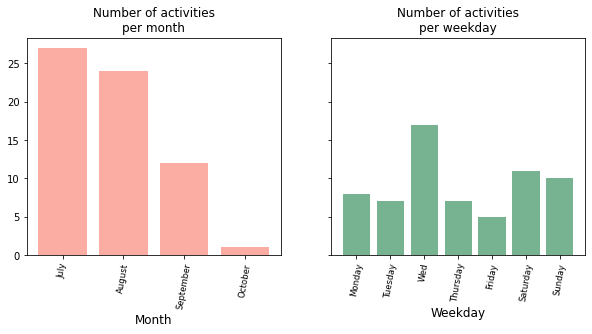

In [9]:
#First setup a plot with multiple subplots that will share the Y axis

#intatiate the figure
rows= 1
cols= 2
fig, axs = plt.subplots(rows, cols, figsize=(10,4), sharey= True)
#create first bar plot for the month frequency
axs[0].bar(month['month'], month['datafile'], color='salmon', alpha=0.65)
axs[0].set_xticks((list(month['month'])))
axs[0].set_xticklabels(['July','August','September','October'], fontsize=8.5)
axs[0].set_xlabel('Month', fontsize=12)
axs[0].set_title('Number of activities\nper month')
#create second bar plot for the weekday frequency
axs[1].bar(day['weekday'], day['datafile'], color='seagreen', alpha=0.65)
axs[1].set_xticks((list(day['weekday'])))
axs[1].set_xticklabels(['Monday','Tuesday','Wed','Thursday','Friday', 'Saturday','Sunday'], fontsize=8.5)
axs[1].set_xlabel('Weekday', fontsize=12)
axs[1].set_title('Number of activities\nper weekday')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=80)

We can observe that our user was very active during the months of July and August and that his favorite day to be active was on Wednesdays followed by Saturdays and Sundays. 

Now let's take a look at the distributions of the heart rate, duration, and distance of the activities. First, I'll create some dataframes aggregated by activity so that we can calculate the average heart rate and duration of each activity file.

In [10]:
#create helper dataframe for calculating mean heart rate per activity
beats1= []
for activity, group in df1.groupby('datafile'):
    aver= np.mean(group['heart_rate'])
    beats1.append({'hr': aver})
beats1 = pd.DataFrame(beats1)
beats1.dropna(inplace=True)
beats1.head()

#create helper dataframe for calculating activity duration
starts= []
ends= []
durations= []
for activity, group in df1.groupby('datafile'):
    tiempo= pd.DataFrame()
    tiempo['time']= group['time']
    start= tiempo['time'].min()
    end= tiempo['time'].max()
    duration= datetime.combine(date.min, end) - datetime.combine(date.min, start)
    starts.append(start)
    ends.append(end)
    durations.append(duration)
    #print(activity, start, end, duration)
duration_df = pd.DataFrame(list(zip(starts, ends, durations)), columns=['start','end','duration'])
duration_df['duration'] = duration_df['duration'].astype('timedelta64[m]')
duration_df= duration_df.drop(duration_df['duration'].idxmin())#----------------------->Dropping extreme hr reads
duration_df= duration_df.drop(duration_df['duration'].idxmax())#----------------------->Dropping extreme hr reads

#create a helper dataframe for distance of activity
distance= []
for activity, group in df1.groupby('datafile'):
    dist= np.max(group['distance'])
    distance.append({'dist': dist})
distance= pd.DataFrame(distance)
distance= distance.drop(distance['dist'].idxmax())
distance= distance.drop(distance['dist'].idxmax())
distance= distance.drop(distance['dist'].idxmax())

Next we plot the heart rate and duration distributions along with a calculated normal curve for reference using the dataframes created above. 

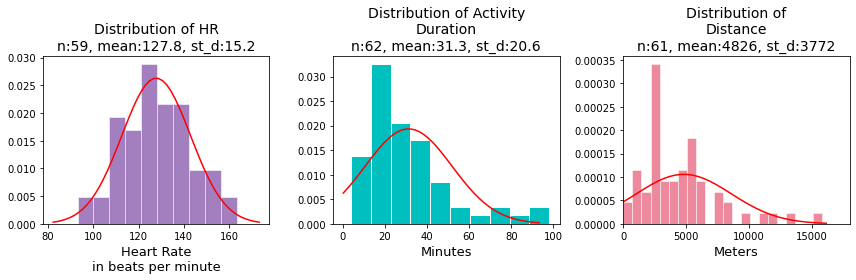

In [11]:
#general plot parameters
opacity= 0.5
opacity1= 0.6

#initialize a figure we 2 subplots
fig1, axs1 = plt.subplots(1, 3, figsize=(12,4), sharey=False)

#heart rate distributions, first we calculate the mean and standard deviation to use for plotting a normal curve
mean, st_d= np.mean(beats1['hr'].dropna()), np.std(beats1['hr'].dropna())
x_normal= np.linspace(mean-3*st_d, mean+3*st_d)

#first subplot for the average hear rate distribution by activity
axs1[0].hist(beats1['hr'].dropna(), density= True, edgecolor='w', color='indigo', alpha= opacity)
axs1[0].plot(x_normal, stats.norm.pdf(x_normal, mean, st_d), color='r')#----->Overlay calculated distribution
axs1[0].set_title(label= None, size=14)
axs1[0].title.set_text('{}\nn:{}, mean:{}, st_d:{}'.format
                       ('Distribution of HR',len(beats1),round(mean,1), round(st_d,1)))
axs1[0].set_xlabel('Heart Rate\nin beats per minute', fontsize=13)

#second subplot for the duration of the activity
axs1[1].hist((duration_df['duration']), density=True, bins=10, edgecolor='w', color='c')
mean_t, st_dt= np.mean(duration_df['duration']), np.std(duration_df['duration'])
x_normalt= np.linspace(mean_t-1.5*st_dt, mean_t+3*st_dt)
axs1[1].plot(x_normalt, stats.norm.pdf(x_normalt, mean_t, st_dt), color='r')#----->overlay calculated distribution
axs1[1].set_title(label= None, size=14)
axs1[1].title.set_text('{}\nn:{}, mean:{}, st_d:{}'.format('Distribution of Activity\nDuration',len(duration_df),round(mean_t,1), round(st_dt,1)))
axs1[1].set_xlabel('Minutes', fontsize=13)

#distance distributions, first we calculate the mean and standard deviation to use for plotting a normal curve
mean_d, st_dd= np.mean(distance['dist'].dropna()), np.std(distance['dist'].dropna())
x_normald= np.linspace(mean_d-3*st_dd, mean_d+3*st_dd)

#first subplot for the average hear rate distribution by activity
axs1[2].hist(distance['dist'].dropna(), density= True, bins= 30, edgecolor='w', color='crimson', alpha= opacity)
axs1[2].plot(x_normald, stats.norm.pdf(x_normald, mean_d, st_dd), color='r')
axs1[2].set_title(label= None, size=14)
axs1[2].title.set_text('{}\nn:{}, mean:{}, st_d:{}'.format('Distribution of\nDistance',len(distance),round(mean_d), round(st_dd)))
axs1[2].set_xlabel('Meters', fontsize=13)
axs1[2].set_xlim(0,18000)

plt.tight_layout()    
plt.show()

One last distrubion visualization that I will use is the SPLOM where I intend to visualize the relantionship between heart rate, duration and distance of each activity. I'll use the same for loop as before to aggregate the data at the activity level.

In [12]:
#creating a helper dataframe that extracts the average heart rate per activity, along with the distance and duration
hr_duration_dist = []
for activity, group in df1.groupby('datafile'):
    hr= np.mean(group['heart_rate'])#-------------->mean heart rate per activity
    dist= np.max(group['distance'])#--------------->max distance per activity
    file= group['datafile']
    day= np.max(group['weekday'])
    #creating a nested dataframe to calculate the duration of the activity by subtracting the min timestamp from the max per activity
    tiempo= pd.DataFrame()
    tiempo['time']= group['time']
    start= tiempo['time'].min()
    end= tiempo['time'].max()
    duration= datetime.combine(date.min, end) - datetime.combine(date.min, start)
    starts.append(start)
    ends.append(end)
    durations.append(duration)
    hr_duration_dist.append({'file':file, 'dist':dist, 'hr':hr, 'duration': duration, 'day':day})

hr_duration_dist= pd.DataFrame(hr_duration_dist)
hr_duration_dist.dropna(subset=['hr'],inplace=True)
hr_duration_dist['duration'] = hr_duration_dist['duration']/ np.timedelta64(1, 's')
hr_duration_dist= hr_duration_dist.drop(hr_duration_dist['duration'].idxmax())
hr_duration_dist= hr_duration_dist.drop(hr_duration_dist['duration'].idxmax())
hr_duration_dist['day'] = hr_duration_dist['day'].map(week_dict)

Using the helper dataframe I can use the Seaborn library to create a SPLOM. I'll use the week day of the activity file to change the hue. 

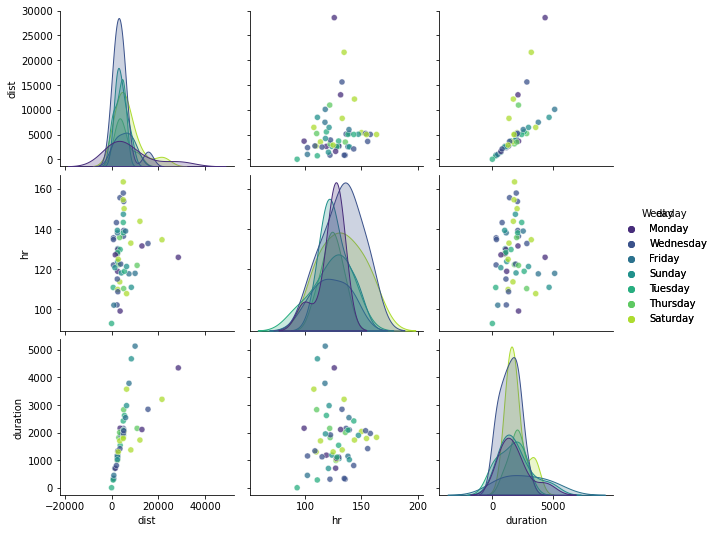

In [13]:
pairplot= sns.pairplot(hr_duration_dist, hue='day', plot_kws={'alpha':0.75}, palette='viridis')
pairplot.add_legend(title= 'Weekday', adjust_subtitles=True)
plt.show()

## GeoMaps

In the next sections I explore the geographical locations of the activities in 2D and 3D. First I start projecting the coordinates over a 2D plot using Folium. Note that I'm assigning a different color to each one of the activities randomly, so everytime the cell is ran, the routes will be in a different color. Also, I added a marker for the ending location of the activity along with the time. Curiously, all the activities end late into the night, so I'm not sure if our user is a night owl, or the timezone is incorrect.

In [14]:
#center map using avegate lat and long coordinates
lat_center= np.mean(df1['lat_degrees'])
long_center= np.mean(df1['long_degrees'])
colors_list1= list(mcolors.cnames.values())#------------------------------>Create an iterable list of colors

#initialize 2d map
mapa= folium.Map(location=[lat_center, long_center], tiles= 'Stamen Terrain', zoom_start=12)

#create a for loop that iterates over each of the activities, extracting coordinates
counter=0
for name, group in df1.groupby(by='datafile'):
    coord = pd.DataFrame()
    coord['lat'], coord['long'] = group['lat_degrees'], group['long_degrees']#----->creates helper dataframe for the coordinates
    folium.Marker([coord['lat'].iloc[-1], coord['long'].iloc[-1]], 
                  popup= 'End: {}'.format(str(group['timestamp'].iloc[-1]))).add_to(mapa)#--->#add marker to the end of the activities
    folium.PolyLine(locations= coord, weight=4,
                    color = colors_list1[np.random.randint(0,147 + 1)]).add_to(mapa)#-->create a line for each of the activities
display(mapa)

On the next plot, still using a 2D map and with the help of Folium I'll use a heatmap to see the routes most frequented by our user, with blue representing the least visited routes and red for the most frequented areas.

In [15]:
#import HeatMap plugin
mapa1= folium.Map(location=[lat_center, long_center], tiles= 'Stamen Terrain', zoom_start=12.2)

from folium.plugins import HeatMap
counter=0
for name, group in df1.groupby(by='datafile'):
    coord = pd.DataFrame()
    coord['lat'], coord['long'] = group['lat_degrees'], group['long_degrees']
    hour_index= group['time']
    #print(coord)
    HeatMap(coord, min_opacity=2, max_zoom= 11,radius=8.5, 
           gradient={0.35:'blue', 0.65:'lime', 1:'red'}).add_to(mapa1)
display(mapa1)

Now, to take advantage of the next variable in the geo dimensional space, I will create a 3D rendering of the activities. Matplotlib offers that option with the Axes3D feature. The 3D map has a different color for each activity.

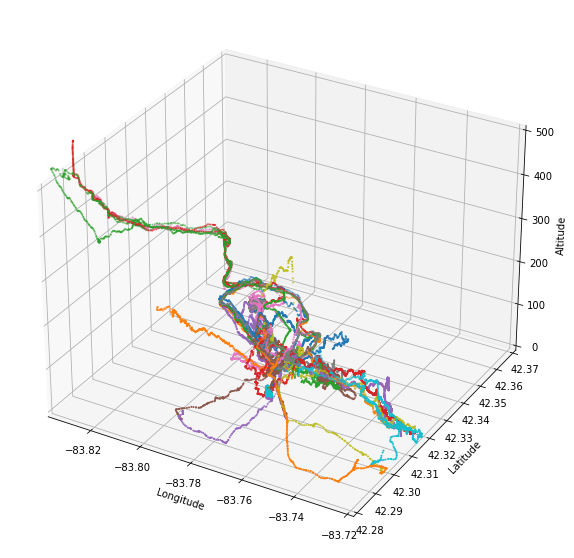

In [19]:
#rides= [ride for ride in df1.groupby(by)]
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig2= plt.figure(figsize=(15,10))
ax= fig2.gca(projection= '3d')


for activity, group in df1.groupby('datafile'):
    artist= ax.scatter(group['long_degrees'], group['lat_degrees'], group['enhanced_altitude'], 
              s=1)
ax.set_xlim(-83.835,-83.72)
ax.set_ylim(42.28,42.37)
ax.set_zlim(0,500)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Altitude')
plt.show()


I think I would be helpful to be able to see the rotation of the graph in 3D to get a good perspective of the geographical dispersion of the activities. Honestly, I found that working with animations is very interesting and challenging and I used the same code that was provided in the sample Mapping file for this course. 

## Conclusion

I provided step by step description of the creation of visuals for the activity file provided in the course assets. Also, I modularized my code and commented it where appropriate with the idea of allowing for exploration and replicability by interested parties. Finally, I also used a level of version control to at least provide with the versions of the packages used to create this file.

In [ ]:
%watermark --iversions